In [335]:
#%pip install torch torchvision torchaudio
# %pip install wordcloud matplotlib
import pandas as pd
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from torch.optim import Adam
from tqdm import tqdm

from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import re

In [338]:
json_file_path = 'News_Category_Dataset_IS_course.json'

with open(json_file_path, 'r') as file:
    lines = file.readlines()

json_data = '[' + ','.join(lines) + ']'
df = pd.read_json(json_data)
df = df[["short_description", "category"]]
df = df.rename(columns={"short_description": "text", "category": "label"})

# nltk.download('stopwords')
# nltk.download('punkt')

# def remove_stopwords_and_punctuation(text):
#     if isinstance(text, str):
#         stop_words = set(stopwords.words('english'))
#         words = word_tokenize(text)
#         # Remove stop words and punctuation
#         filtered_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
#         return ' '.join(filtered_words)
#     else:
#         return text

# df['text'] = df['text'].apply(remove_stopwords_and_punctuation)

table = str.maketrans('', '', string.punctuation)

def text_process(mess):
    if isinstance(mess, str):
        words = re.split(r'\W+', mess)
        nopunc = [w.translate(table) for w in words]
        nostop =  ' '.join([word for word in nopunc if word.lower() not in stopwords.words('english')])
        return nostop
    else:
        return mess

df['text'] = df.apply(lambda row: text_process(row.text), axis=1)

unique_categories = sorted(df["label"].unique())

label2id = {}
id2label = {}
for index, category in enumerate(unique_categories):
    label2id[category] = index
for key in label2id.keys():
    id2label[label2id[key]] = key

text_data = df["text"]

df = df.loc[:999, :]

/var/folders/yd/typqllh91wbfnhg4gx4s62b00000gn/T/ipykernel_22143/4057749916.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json_data)


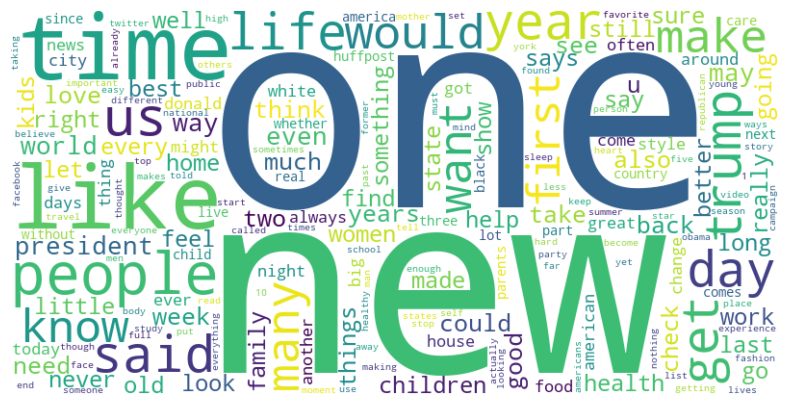

In [339]:
words = []
for text in text_data:
    if text is not None:
        words.extend(word_tokenize(text.lower()))

word_freq = Counter(words)

wordcloud = WordCloud(width=800, height=400, background_color='white')

wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [340]:
print(word_freq)

Counter({'one': 9583, 'new': 7804, 'time': 7245, 'like': 6850, 'people': 6572, 'us': 5561, 'said': 5234, 'trump': 5200, 'get': 4981, 'year': 4918, 'life': 4908, 'day': 4781, 'make': 4395, 'would': 4386, 'want': 4244, 'many': 4189, 'know': 4099, 'first': 4093, 'president': 3916, 'even': 3873, 'may': 3802, 'way': 3758, 'world': 3695, 'week': 3374, 'years': 3361, 'could': 3323, 'take': 3320, 'love': 3318, 'think': 3247, 'also': 3172, 'good': 3162, 'much': 3141, 'two': 3084, 'back': 3008, 'see': 3003, 'need': 2998, 'best': 2837, 'say': 2819, 'health': 2791, 'last': 2735, 'every': 2665, 'things': 2651, 'right': 2591, 'look': 2579, 'well': 2571, 'go': 2555, 'still': 2521, 'really': 2519, 'help': 2517, 'something': 2494, 'never': 2399, 'children': 2395, 'little': 2387, 'home': 2375, 'work': 2372, 'going': 2346, 'old': 2294, 'kids': 2204, 'made': 2202, 'women': 2185, 'long': 2178, 'family': 2177, 'feel': 2115, 'show': 2114, 'u': 2092, 'better': 2082, 'sure': 2075, 'check': 2040, 'says': 2038, 

In [239]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_categories), id2label=id2label, label2id=label2id)
model.to("mps")

mask = df["text"].notnull()
filtered_df = df[mask]

np.random.seed(112)
df_train, df_val, df_test = np.split(filtered_df.sample(frac=1, random_state=42), 
                                     [int(.8*len(filtered_df)), int(.9*len(filtered_df))])

print(len(df_train), len(df_val), len(df_test))

text_train = df_train["text"].tolist()
label_train = df_train["label"]
inputs_train = tokenizer(text_train, padding=True, truncation=True, return_tensors="pt")
labels_train = torch.tensor(label_train.map(label2id).tolist())

inputs_train_to_tensor = []
for i in range(len(inputs_train.input_ids)):
    obj = {
        "input_ids": inputs_train.input_ids[i],
        "attention_mask": inputs_train.attention_mask[i],
        "token_type_ids": inputs_train.token_type_ids[i],
        "label": labels_train[i],
    }
    inputs_train_to_tensor.append(obj)
inputs_train = inputs_train_to_tensor

text_val = df_val["text"].tolist()
label_val = df_val["label"]
inputs_val = tokenizer(text_val, padding=True, truncation=True, return_tensors="pt")
labels_val = torch.tensor(label_val.map(label2id).tolist())

inputs_val_to_tensor = []
for i in range(len(inputs_val.input_ids)):
    obj = {
        "input_ids": inputs_val.input_ids[i],
        "attention_mask": inputs_val.attention_mask[i],
        "token_type_ids": inputs_val.token_type_ids[i],
        "label": labels_val[i],
    }
    inputs_val_to_tensor.append(obj)
inputs_val = inputs_val_to_tensor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


794 99 100


In [241]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs[idx]["input_ids"],
            "attention_mask": self.inputs[idx]["attention_mask"],
            "label": self.labels[idx],
        }
        
# train_dataset = MyDataset(train_inputs, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [242]:
# dataset_train = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
dataset_train = Dataset(inputs_train, labels_train)
# dataset_val = TensorDataset(inputs_val['input_ids'], inputs_val['attention_mask'], labels_val)
dataset_val = Dataset(inputs_val, labels_val)

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

In [273]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }
    

In [274]:
training_args = TrainingArguments(
    output_dir='./output_dir',
    do_train=True,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    do_eval=True,
    use_mps_device=True,
    save_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    compute_metrics=compute_metrics
)

trainer.train()

/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/transformers/training_args.py:1897: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
26it [39:59, 92.30s/it]
 33%|███▎      | 50/150 [00:22<00:25,  3.99it/s]



/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                


                                    
 33%|███▎      | 50/150 [00:22<00:25,  3.99it/s]





{'eval_loss': 0.8030497431755066, 'eval_Accuracy': 0.8787878787878788, 'eval_F1': 0.528043694559121, 'eval_Precision': 0.515108759553204, 'eval_Recall': 0.5446913580246914, 'eval_runtime': 0.3236, 'eval_samples_per_second': 305.956, 'eval_steps_per_second': 21.633, 'epoch': 1.0}


 67%|██████▋   | 100/150 [00:35<00:11,  4.31it/s]Checkpoint destination directory ./output_dir/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.




/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 


                                    
 67%|██████▋   | 100/150 [00:36<00:11,  4.31it/s]





{'eval_loss': 0.9137121438980103, 'eval_Accuracy': 0.8686868686868687, 'eval_F1': 0.5344992460186105, 'eval_Precision': 0.5297325102880659, 'eval_Recall': 0.5409876543209876, 'eval_runtime': 0.2882, 'eval_samples_per_second': 343.505, 'eval_steps_per_second': 24.288, 'epoch': 2.0}


100%|██████████| 150/150 [00:49<00:00,  4.28it/s]



/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       
                                                 


                                    
100%|██████████| 150/150 [00:49<00:00,  4.28it/s]





                                       
                                                 
100%|██████████| 150/150 [00:49<00:00,  3.02it/s]

{'eval_loss': 0.8424506187438965, 'eval_Accuracy': 0.8585858585858586, 'eval_F1': 0.5875622173016143, 'eval_Precision': 0.6170510132774284, 'eval_Recall': 0.614320987654321, 'eval_runtime': 0.2595, 'eval_samples_per_second': 381.446, 'eval_steps_per_second': 26.971, 'epoch': 3.0}
{'train_runtime': 49.6787, 'train_samples_per_second': 47.948, 'train_steps_per_second': 3.019, 'train_loss': 0.04509725570678711, 'epoch': 3.0}


TrainOutput(global_step=150, training_loss=0.04509725570678711, metrics={'train_runtime': 49.6787, 'train_samples_per_second': 47.948, 'train_steps_per_second': 3.019, 'train_loss': 0.04509725570678711, 'epoch': 3.0})

In [275]:
# Uncomment these two lines to overwrite previously saved trained model
model.save_pretrained('fine_tuned_model_dir')
tokenizer.save_pretrained('fine_tuned_model_dir')

fine_tuned_model = BertForSequenceClassification.from_pretrained('fine_tuned_model_dir')
fine_tuned_tokenizer = BertTokenizer.from_pretrained('fine_tuned_model_dir')

nlp = pipeline("sentiment-analysis", model=fine_tuned_model, tokenizer=fine_tuned_tokenizer)

In [311]:
nlp("Mariah Carey Brings Big, Big Energy To Latto's 2022 BET Awards Performance")

[{'label': 'ENTERTAINMENT', 'score': 0.9979384541511536}]

In [284]:
text_test = df_test["text"].tolist()
label_test = df_test["label"]
inputs_test = tokenizer(text_test, padding=True, truncation=True, return_tensors="pt")
labels_test = torch.tensor(label_test.map(label2id).tolist())

inputs_test_to_tensor = []
for i in range(len(inputs_test.input_ids)):
    obj = {
        "input_ids": inputs_test.input_ids[i],
        "attention_mask": inputs_test.attention_mask[i],
        "token_type_ids": inputs_test.token_type_ids[i],
        "label": labels_test[i],
    }
    inputs_test_to_tensor.append(obj)
inputs_test = inputs_test_to_tensor

# test_dataset = TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)
test_dataset = Dataset(inputs_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# results = [trainer.evaluate(eval_dataset=x) for x in test_loader.dataset]
results = trainer.evaluate(eval_dataset=val_loader.dataset)

 57%|█████▋    | 4/7 [00:00<00:00, 29.53it/s]/Users/markmihelic/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 7/7 [00:00<00:00, 29.66it/s]


In [318]:
print(f"Accuracy: {results['eval_Accuracy']:.2%}")
print(f"Loss: {results['eval_loss']:.2%}")
print(f"F1: {results['eval_F1']:.2%}")
print(f"Precision: {results['eval_Precision']:.2%}")
print(f"Recall: {results['eval_Recall']:.2%}")
print(f"Runtime: {results['eval_runtime']}s")
print(f"Samples per second: {results['eval_samples_per_second']}")
print(f"Steps per second: {results['eval_steps_per_second']}")
print(f"Epochs: {results['epoch']}")

Accuracy: 85.86%
Loss: 84.25%
F1: 58.76%
Precision: 61.71%
Recall: 61.43%
Runtime: 0.5946s
Samples per second: 166.488
Steps per second: 11.772
Epochs: 3.0
